[View in Colaboratory](https://colab.research.google.com/github/Hoiy/kaggle-avito-demand-prediction/blob/master/Model_LightGBM.ipynb)

In [14]:
import pandas as pd
import numpy as np
import dotenv
import os
from scipy import sparse
import pickle
import gc
import lightgbm as lgb

dotenv.load_dotenv('.env')

True

In [15]:
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/data data
!kaggle competitions download -f sample_submission.csv --path ./data

Building synchronization state...
Starting synchronization...
Using competition: avito-demand-prediction
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
cat_cols = [
    'image_top_1', 
    'region_code', 
    'city_code', 
    'parent_category_name_code', 
    'category_name_code', 
    'user_type_code', 
    'param_1_code', 
    'param_2_code', 
    'param_3_code',
    'user_id_code',
    'item_seq_number_code',
    'activation_date_weekday_code',
    'activation_date_month_code',
    'activation_date_day_code',
    'title_length',
    'title_space_count',
    'description_length',
    'description_space_count',
]
# cont_cols = ['price_std'] + ['title_ft_%d'%i for i in range(32)][:]
cont_cols = ['price_std']


def load_data(t):
  df = pd.read_parquet('./data/%s_prep.snappy.parquet'%t, columns=cat_cols+cont_cols)
#   labels = pd.read_parquet('./data/%s_prep.snappy.parquet'%t, columns=['deal_probability'])['deal_probability']
  
#   prep = sparse.csr_matrix(df.values)
#   title_tfidf = sparse.load_npz('./data/%s_title_tfidf.npz'%t)
#   description_tfidf = sparse.load_npz('./data/%s_description_tfidf.npz'%t)

#   tfidf_features = pickle.load(open('./data/tfidf_feature_names.pl', 'rb'))

#   feature_names = df.columns.tolist() + ['title_%s'%f for f in tfidf_features] + ['description_%s'%f for f in tfidf_features]
  feature_names = df.columns.tolist()
#   features = sparse.hstack([prep, title_tfidf, description_tfidf])
#   features = sparse.hstack([prep])
  
#   del tfidf_features
#   del description_tfidf
#   del title_tfidf
#   del df
#   gc.collect()
  
#   return lgb.Dataset(features, labels, feature_name=feature_names, categorical_feature=cat_cols, free_raw_data=False)
  return df, feature_names

In [0]:
X, X_names = load_data('train')
y = pd.read_parquet('./data/train_prep.snappy.parquet', columns=['deal_probability'])['deal_probability']

In [0]:
#TODO: how to setup gpu lightgbm in colab
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'metric': {'rmse'},
#     'num_leaves': 250,
#     'feature_fraction': 0.50,
#     'bagging_fraction': 0.70,
#     'device': 'gpu',
    'verbose': 1
}

lgb_params = {
    'verbose_eval': 10,
    'categorical_feature': cat_cols,
    'early_stopping_rounds':10
}

In [58]:
K_FOLD=10

results = lgb.cv(
    params,
    lgb.Dataset(X, y),
    stratified=False,
    nfold=K_FOLD,
    seed=42,
    num_boost_round=10000,
    **lgb_params
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['activation_date_day_code', 'activation_date_month_code', 'activation_date_weekday_code', 'category_name_code', 'city_code', 'description_length', 'description_space_count', 'image_top_1', 'item_seq_number_code', 'param_1_code', 'param_2_code', 'param_3_code', 'parent_category_name_code', 'region_code', 'title_length', 'title_space_count', 'user_id_code', 'user_type_code']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[10]	cv_agg's rmse: 0.235801 + 0.000556072
[20]	cv_agg's rmse: 0.230493 + 0.000522923
[30]	cv_agg's rmse: 0.228648 + 0.000510924
[40]	cv_agg's rmse: 0.227675 + 0.000506722
[50]	cv_agg's rmse: 0.22697 + 0.000479663
[60]	cv_agg's rmse: 0.226527 + 0.000496999
[70]	cv_agg's rmse: 0.226231 + 0.000499347
[80]	cv_agg's rmse: 0.226013 + 0.000509882
[90]	cv_agg's rmse: 0.225857 + 0.000515435
[100]	cv_agg's rmse: 0.225724 + 0.000521262
[110]	cv_agg's rmse: 0.225613 + 0.000526917
[120]	cv_agg's rmse: 0.225519 + 0.000529297
[130]	cv_agg's rmse: 0.225439 + 0.000527494
[140]	cv_agg's rmse: 0.225358 + 0.000538075
[150]	cv_agg's rmse: 0.225298 + 0.000543839
[160]	cv_agg's rmse: 0.22525 + 0.000538859
[170]	cv_agg's rmse: 0.225189 + 0.000546411
[180]	cv_agg's rmse: 0.225141 + 0.000537017
[190]	cv_agg's rmse: 0.225106 + 0.000538327
[200]	cv_agg's rmse: 0.225081 + 0.000535654
[210]	cv_agg's rmse: 0.22505 + 0.000540306
[220]	cv_agg's rmse: 0.225012 + 0.000537757
[230]	cv_agg's rmse: 0.224992 + 0.000541502


In [59]:
cv = results['rmse-mean'][-1]
rounds = len(results['rmse-mean'])
rounds, cv, K_FOLD, 1/K_FOLD

(355, 0.22475719961159193, 10, 0.1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/K_FOLD, random_state=42)
        
lgb_train = lgb.Dataset(X_train, y_train, feature_name=X_names)
lgb_val = lgb.Dataset(X_valid, y_valid, feature_name=X_names)

# del X, y; gc.collect()

In [63]:
model = lgb.train(
    params,
    lgb_train,
    valid_names=['train', 'valid'],
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=rounds,
    **lgb_params
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['activation_date_day_code', 'activation_date_month_code', 'activation_date_weekday_code', 'category_name_code', 'city_code', 'description_length', 'description_space_count', 'image_top_1', 'item_seq_number_code', 'param_1_code', 'param_2_code', 'param_3_code', 'parent_category_name_code', 'region_code', 'title_length', 'title_space_count', 'user_id_code', 'user_type_code']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	train's rmse: 0.235466	valid's rmse: 0.235884
[20]	train's rmse: 0.229718	valid's rmse: 0.230379
[30]	train's rmse: 0.227519	valid's rmse: 0.228655
[40]	train's rmse: 0.226057	valid's rmse: 0.227708
[50]	train's rmse: 0.22491	valid's rmse: 0.226982
[60]	train's rmse: 0.224062	valid's rmse: 0.226535
[70]	train's rmse: 0.223351	valid's rmse: 0.226243
[80]	train's rmse: 0.222757	valid's rmse: 0.226027
[90]	train's rmse: 0.222242	valid's rmse: 0.225864
[100]	train's rmse: 0.221735	valid's rmse: 0.225752
[110]	train's rmse: 0.221255	valid's rmse: 0.225627
[120]	train's rmse: 0.220873	valid's rmse: 0.225533
[130]	train's rmse: 0.220468	valid's rmse: 0.225463
[140]	train's rmse: 0.22005	valid's rmse: 0.225387
[150]	train's rmse: 0.219688	valid's rmse: 0.225356
[160]	train's rmse: 0.219322	valid's rmse: 0.225295
[170]	train's rmse: 0.219007	valid's rmse: 0.225279
[180]	train's rmse: 0.21871	valid's rmse: 0.225234
[190]	train's 

Text(0.5,1,'Light GBM Feature Importance')

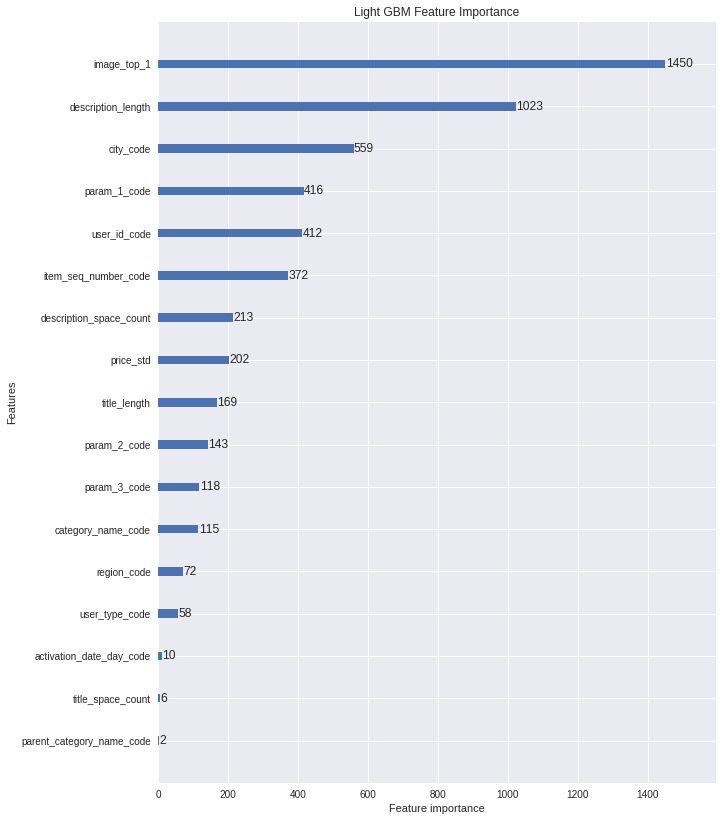

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [0]:
model.save_model('lightgbm.dat')

In [17]:
del model, lgb_train, lgb_val; gc.collect()

NameError: ignored

In [0]:
test = pd.read_parquet('./data/test_prep.snappy.parquet').set_index('item_id')
X_test, _ = load_data('test')
submission = pd.read_csv('./data/sample_submission.csv').set_index('item_id')
# model = lgb.Booster(model_file='lightgbm.dat')

In [0]:
SUBMISSION_FILE='lightgbm.csv'
SUBMISSION_MESSAGE='"LightGBM tfidf"'

# TODO: how to limit LightGBM regression mode to output [0., 1]
test['deal_probability'] = model.predict(X_test).clip(0., 1.)
submission['deal_probability'] = test['deal_probability'].reindex(submission.index)
submission.to_csv(SUBMISSION_FILE)

In [0]:
assert len(test.index) == len(submission.index)

In [49]:
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: avito-demand-prediction
Successfully submitted to Avito Demand Prediction Challenge